# Importing Packages Needed

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as py
from scipy.optimize import curve_fit
#from scipy.signal import find_peaks
import collections as col
from scipy.interpolate import UnivariateSpline

# Definition of Named Tuples

In [2]:
component = col.namedtuple('component','phase intensity')
ind_sub = col.namedtuple('ind_sub','phase intensity width')
pulse_sub = col.namedtuple('pulse_sub','frequency sub1 sub2, errors')
pulse_fits = col.namedtuple('pulse_fits','thorsett, powerlaw, linear')
one_fit = col.namedtuple('one_fit','params, errors, cov, chir')
pl_av = col.namedtuple('pl_av', 'frequency, phase')

# Definition of Functions

Functions needed to calculate chi squared values and find error in pulse data

In [3]:
def chsq(observed_values, expected_values, err):
    """
    Chi Squared operation:
    Compute the data's chi squared values.
    
    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
    """
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

In [4]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Sigma clipping operation:
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.

    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            #print("Took {0} trials to reach tolerance".format(trial+1))
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            #print("Reached number of trials without reaching tolerance level")
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

Gaussian Fitting Functions:

In [5]:
"""
Definitions of gaussian equations - single, double and triple
"""

def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))

def twogauss(x,amp1,cen1,sd1,amp2,cen2,sd2):
    return gauss(x,amp1,cen1,sd1)+gauss(x,amp2,cen2,sd2)

def threegauss(x,amp1,cen1,sd1,amp2,cen2,sd2,amp3,cen3,sd3):
    return gauss(x,amp1,cen1,sd1)+gauss(x,amp2,cen2,sd2)+gauss(x,amp3,cen3,sd3)

In [6]:
"""
Fitting data into the above gaussian equations. 

Parameters:
    -----------
    x,y: list, list
        A list of floats - the data 
    error: float
        The error across all data - standard deviation of the noise
    expect: list
        The expected parameters for the gaussian equation

    Returns:
    --------
    params: list
        The parameters (x, cen, sd) of the fit
    cov: list
        The covariance of the fit
    fit: list
        The y data of the actual fit (parameters have been put back into the equation)
    chi: float
        The chi squared value
"""

def single_fit(x, y, error, expect):
    params,cov=curve_fit(gauss,x,y,expect,bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,np.inf]))
    fit=gauss(x,*params)
    
    chi=chsq(y, fit, error)
    chir=chi/(len(y)-3)
        
    return params, cov, fit, chir

def double_fit(x, y, error, expect):
    params,cov=curve_fit(twogauss,x,y,expect,bounds=([-np.inf,-np.inf,0,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    fit=twogauss(x,*params)

    chi=chsq(y, fit, error)
    chir=chi/(len(y)-6)
    
    return params, cov, fit, chir

def triple_fit(x, y, error, expect):
    params,cov=curve_fit(threegauss,x,y,expect,bounds=([-np.inf,-np.inf,0,-np.inf,-np.inf,0,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    fit=threegauss(x,*params)
    
    chi=chsq(y, fit, error)
    chir=chi/(len(y)-9)
    
    return params, cov, fit, chir

In [7]:
"""
    Fitting Gaussians operation:
    Creates a double gaussian fit for the data.
    First attempts a fit with expected left subpulse, and if this fails it then attempts a fit with the right. 
    If these fail create a no fit.
    
    Then checks if a double fit is created, the chi value and if over 1100, replaces it with a single fit instead. 
    If chi of a single fit is still above 1100 then replaces it with a no fit. 

    Parameters:
    -----------
    x, y: list, list
        A list of floats - the data 
    error: float
        The error across all data - standard deviation of the noise
        
    Returns:
    --------
    fit: list
        The y data of the best fit 
    params: list
        The parameters (x, cen, sd) of the best fit
    sigma: list
        List of the errors in the parameters
    chi: float
        The chi squared reduced value
""" 

def fitting_gaussians(x,y, error):   
    mx=max(y)
    yl=list(y)
    mx_ind=yl.index(mx)
    mx_ph=x[mx_ind]
    
    #Attempts to use the peak of the data as an expected value, if it is in the correct range
    if mx_ph>300 and mx_ph<550:
        expect1=[mx,mx_ph,20,20,700,100]
    else:
        expect1=[70,400,20,20,700,100]
    if mx_ph>550 and mx_ph<700:
        expect2=[20,400,100,mx,mx_ph,20]
    else:
        expect2=[20,400,100,70,700,20]
    
    #Attempts to first create a fit using expected left peak
    try:
        params1, cov1, fit1, chir1 = double_fit(x, y, error, expect1)
        sigma1=np.sqrt(np.diag(cov1))
    except Exception as e:
        params1=0
        fit1=[]
        chir1=5000
        sigma1=0
        cov1=0
    #Then attempts to create a fit using expected right peak
    try:
        params2, cov2, fit2, chir2 = double_fit(x, y, error, expect2)
        sigma2=np.sqrt(np.diag(cov2))
    except Exception as r:
        params2=0
        fit2=[]
        chir2=5000
        sigma2=0
        cov2=0
    
    #Then use the fit with the best chi squared reduced value
    if abs(chir1-1)<=abs(chir2-1) and abs(chir1-1)<2:
        params=params1
        fit=fit1
        chir=chir1
        sigma=sigma1
        cov=cov1
    elif abs(chir2-1)<=abs(chir1-1) and abs(chir2-1)<2:
        params=params2
        fit=fit2
        chir=chir2
        sigma=sigma2 
        cov=cov2
    else:
        params=0
        fit=[]
        chir=np.inf
        sigma=0
        cov=0
        
    return fit, params, sigma, cov, chir

Finding Peak of Gaussian Fittings Function

In [8]:
def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [9]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian

    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

In [10]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all roots of a gaussian function

    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
            
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)

    return minima, maxima, minima_e, maxima_e

In [11]:
def gauss_peaksn(fit, nofreqband, freqband, cov, params,freq_low,freq_high):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    noise_std: int
        the standard deviation of the noise - the error of the data
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    minima, peakpos, minima_e, err=find_minima_maxima_gauss(params, cov, len(fit))
    peakint = twogauss(peakpos, *params)
    
    #Delete the peak with the least intensity until there is only one peak left
    while len(peakpos)>1:
        mn=min(peakint)
        peakint = list(peakint)
        rm = peakint.index(mn)
        del peakpos[rm]
        del peakint[rm]
        del err[rm]
    
    #Assign the peaks to be either subpulse 1 or 2, also converts phase from bins to degrees
    if len(peakpos)==1 and peakint[0]>20:
        component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
        component2 = component(phase=0, intensity=0)
        error = np.array(err)*(deg_mod)
    else:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0

    #Converts the frequency from bins to MHz    
    freq=(((freq_high-freq_low)/nofreqband)*(nofreqband-freqband))+freq_low
    profile_comp = pulse_sub(frequency=freq, sub1=component1, sub2=component2, errors=error)

    return profile_comp

Plotting Fittings Functions

In [12]:
"""
    Plotting operations:
    Used to make different plots of the fits, their components and peaks.
"""
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

In [13]:
def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)
    
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
  
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)

    return 

In [14]:
def plot_peaks(x,y,profile_comp):
    py.plot((360/1024)*x,y, lw=0.5)
    py.plot((360/1024)*x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Component Movement Data

In [15]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))
def linear(x, m, c):
    return (x * m+c)

In [16]:
def jacobian_slope_pl(length,x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def ddA(A, alpha, x):
        return (1/length)*x**alpha
    def ddalpha(A, alpha, x):
        return (1/length)*alpha*A*x**(alpha-1)
    J = []
    for i in range(0, len(params), 2):
        A = params[i]
        alpha = params[i+1]
        mypars = [A, alpha, x]
        J.append(ddA(*mypars))
        J.append(ddalpha(*mypars))
    J = np.asmatrix(J)
    return J

In [17]:
def find_y_err_pl(x, popt, pcov):
    #x=list of all frequencys. popt = parameter list across all pulses. pcov=covarience matrix for all pulses
    #Combine multiple cov matrices into one
    cov=np.zeros((len(pcov)*2,len(pcov)*2))
    for i, c in enumerate(pcov):
        cov[i*2][i*2]=c[0][0]
        cov[i*2][i*2+1]=c[0][1]
        cov[i*2+1][i*2]=c[1][0]
        cov[i*2+1][i*2+1]=c[1][1]
    err=[]
    for i, point in enumerate(x):
        J = jacobian_slope_pl(len(x),point, *popt)
        JC = np.matmul(J, cov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        err.append(sigma_y)
    return err
#returns a list of errors

Extra Stuff

In [18]:
"""
    Graphing Sub-pulse operation:
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_spulse(fit_spulse,spulse_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        if spulse_num==1:
            for i in range(0,len(fit_spulse)):
                if fit_spulse[i][1][0] != 0:# and fit_spulse[i][3][0]<4:
                    phase_comp.append(fit_spulse[i][1][0])
                    frequency_comp.append(fit_spulse[i][0])
                    comp_err.append(fit_spulse[i][3][0])
        elif spulse_num==2:
            for i in range(0,len(fit_spulse)):
                if fit_spulse[i][2][0] != 0:# and fit_spulse[i][3][3]<4:
                    phase_comp.append(fit_spulse[i][2][0])
                    frequency_comp.append(fit_spulse[i][0])
                    comp_err.append(fit_spulse[i][3][0])
        
        return phase_comp, frequency_comp, comp_err    

In [19]:
"""
    Removing outliers operation
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors.
"""
def detect_outlier(frequency_comp, phase_comp, comp_err):
    phase=[]
    frequency=[]
    err=[]
    
    threshold=1.5
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    
    for i in range(len(phase_comp)):
        z_score= (phase_comp[i] - mean_1)/std_1 
        if np.abs(z_score) < threshold:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

In [20]:
"""
    Three fits operation
    Attempts to fit a thorsett, power law and linear equation to the data. Also calculates chi squared and reduced 
"""

def three_fits(frequency_comp, phase_comp, comp_err): 
    
    try:
        expect=[100,0.1,0.1]
        thorsett_params,thorsett_cov=curve_fit(thorsett,frequency_comp,phase_comp, expect, maxfev=100000, sigma=comp_err)
        thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
        thorsettf = thorsett(frequency_comp, *thorsett_params)

        ch=chsq_err(phase_comp,thorsettf, comp_err)
        chre=ch/(len(phase_comp)-3)

        thorsett_fit=one_fit(params=thorsett_params, errors=thorsett_fit_error, cov=thorsett_cov, chir=chre)  
    except:
        print('No thorsett for component')
        thorsett_fit=0

    try:
        expect=[100,0.1]
        pl_params,pl_cov=curve_fit(powerlaw,frequency_comp,phase_comp, expect, maxfev=100000, sigma=comp_err)
        pl_fit_error=np.sqrt(np.diag(pl_cov))
        powerlawf = powerlaw(frequency_comp, *pl_params)

        ch=chsq_err(phase_comp,powerlawf, comp_err)
        chre=ch/(len(phase_comp)-2)
        
        pl_fit=one_fit(params=pl_params, errors=pl_fit_error, cov=pl_cov, chir=chre)
    except:
        print('No power law for component')
        pl_fit=0

    try:
        lin_params,lin_cov=curve_fit(linear,frequency_comp,phase_comp)
        lin_fit_error=np.sqrt(np.diag(lin_cov))
        linearf = linear(np.array(frequency_comp), *lin_params)
       
        ch=chsq_err(phase_comp,linearf, comp_err)
        chre=ch/(len(phase_comp)-2)
        
        lin_fit=one_fit(params=lin_params, errors=lin_fit_error, cov=lin_cov, chir=chre)
    except:
        print('No linear for component')
        lin_fit=0
        
    pulse_fit=pulse_fits(thorsett=thorsett_fit, powerlaw=pl_fit, linear=lin_fit)
    
    return pulse_fit

# INDIVIDUAL FREQUENCY BAND

## Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

In [21]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [22]:
single_pulse = np.loadtxt(fname='/home/lisasmith/sspulsar/archivefiles/s_archivefiles/f256_new/pulse_1503960513.f256_pazi.pdv', dtype=fulldatatype)

In [23]:
no_freq_bands = max(single_pulse['frequency'])+1

## Gaussian Fitting - Broken Down for Each Frequency

Following Section is for error checking:

From all the frequency profiles it takes only the one frequency band. 

In [24]:
#Isolating a single frequency for a pulse
freqband = 5
f = single_pulse['frequency'] == freqband

phase=single_pulse['phase'][f]
intensity=single_pulse['intensity'][f]
x = phase
y = intensity

In [25]:
len(y)

1024

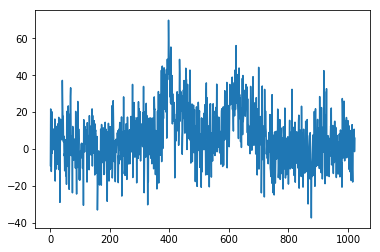

In [26]:
py.plot(x,y)

Calculates the noise of the data. The standard deviation of this is then the error in the data. 

In [27]:
noise = sigmaClip(y)
error = np.nanstd(noise[1])
print(error)

14.899773325708042


In [28]:
#Attempts to fit two gaussians to the data
#Uses two expected values and returns the fit with the best chi squared reduced values
fit, params, sigma, cov, chir=fitting_gaussians(x,y,error)

pulse_sub(frequency=433.33333333333337, sub1=component(phase=144.53444988134603, intensity=28.095299069572754), sub2=component(phase=0, intensity=0), errors=array([1.17297241]))


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


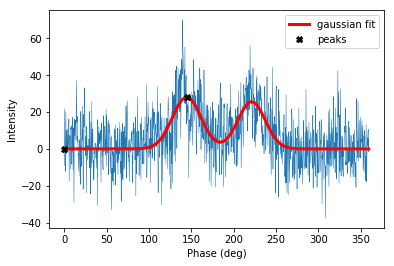

In [29]:
#If there is a fit, finds peaks where derivative is equal to zero, and then takes the highest peak
#Also classifys it as subpulse 1 or 2 depending on location
if fit!=[]:
    pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500)
    plot_peaks(x,y, pulse_subp)
    print(pulse_subp)

# INDIVIDUAL PULSE

## Gaussian Fitting 

The following is a looped version of the previous section to find the correct peaks for each frequency profile

In [30]:
fit_spulse = []

In [31]:
for i in range(no_freq_bands):
    
    freqband = i
  
    f = single_pulse['frequency'] == freqband

    x=single_pulse['phase'][f]
    y=single_pulse['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])
    
    if len(y)!=0:
        fit, params, sigma, cov, chir=fitting_gaussians(x,y,error)
        
    if fit!=[] and len(y)!=0:
        pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500) 
        fit_spulse.append(pulse_subp)
    

/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


## Change of Peak Position over Frequency

Starting to graph out all the movement of sub-pulse phase across frequency

---



In [32]:
#Separate the data into the correct arrays for graphing
try:
    phase_comp1, frequency_comp1, comp1_err=graphing_spulse(fit_spulse,1)
    sp1 = "PENDING"
except:
    print("Bad Data Set Comp1")
    sp1 = "ERROR"

In [33]:
if sp1!="ERROR":
    if len(phase_comp1)<3:
        sp1 = "ERROR"

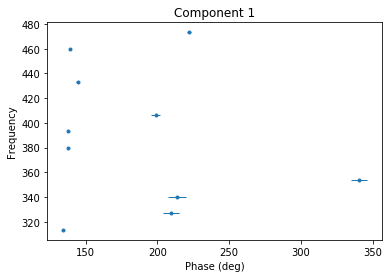

In [34]:
if sp1!="ERROR":
    py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=1, label='data')
    py.title('Component 1')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')

In [35]:
#Remove outliers
if sp1!="ERROR":
    frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err)
if sp1!="ERROR":
    if len(phase_comp1)<3:
        sp1 = "ERROR"

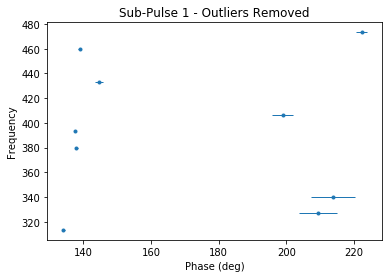

In [36]:
if sp1!="ERROR":
    py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=1, label='data')
    py.title('Sub-Pulse 1 - Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')

## Fitting Power Laws to Position

### Component 1

The thorsett equation of fit for this pulse is: 	 Phase = 0.000 ν^115.228 + 136.723
The errors are inf, inf, inf
The chi squared reduced is 87.60939448333534, and the chi squared is 815.484550350018

The power law equation of fit for this pulse is: 	 Phase = 38.913 ν^0.214
The errors are 49.70992255651331, 0.21511350962071676
The chi squared reduced is 384.8085594482984, and the chi squared is 3481.2770350346855

The linear equation of fit for this pulse is: 		 Phase = -0.007 ν + 173.524 
The errors are 0.25469100266179395, 100.75240335524305
The chi squared reduced is 3923.0801526258324, and the chi squared is 35325.72137363249


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/home/lisasmith/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


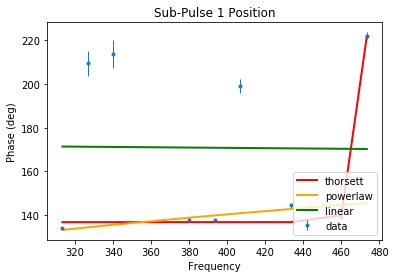

In [37]:
#Same as the three fits function but with graphing included
if sp1!="ERROR":
    py.errorbar(frequency_comp1,phase_comp1, yerr=comp1_err, fmt='.', lw=1, label='data')

    try:
        thorsett_params1,thorsett_cov1=curve_fit(thorsett,frequency_comp1,phase_comp1, maxfev=100000, sigma=comp1_err)
        thorsett_fit_error1=np.sqrt(np.diag(thorsett_cov1))
        thorsett1 = thorsett(frequency_comp1, *thorsett_params1)
        
        py.plot(frequency_comp1,thorsett1, color='red',lw=2,label='thorsett')
        
        ch=chsq_err(phase_comp1,thorsett1, comp1_err)
        chre=ch/len(phase_comp1)-3
        print(f'The thorsett equation of fit for this pulse is: \t Phase = {thorsett_params1[0]:.3f} \u03BD^{thorsett_params1[1]:.3f} + {thorsett_params1[2]:.3f}')
        print(f'The errors are {thorsett_fit_error1[0]}, {thorsett_fit_error1[1]}, {thorsett_fit_error1[2]}')
        print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
    except:
        print('No thorsett for component 1')

    try:
        pl_params1,pl_cov1=curve_fit(powerlaw,frequency_comp1,phase_comp1, maxfev=100000, sigma=comp1_err)
        pl_fit_error1=np.sqrt(np.diag(pl_cov1))
        powerlaw1 = powerlaw(frequency_comp1, *pl_params1)

        py.plot(frequency_comp1,powerlaw1, color='orange',lw=2,label='powerlaw')
        
        ch=chsq_err(phase_comp1,powerlaw1, comp1_err)
        chre=ch/len(phase_comp1)-2
        print(f'The power law equation of fit for this pulse is: \t Phase = {pl_params1[0]:.3f} \u03BD^{pl_params1[1]:.3f}')
        print(f'The errors are {pl_fit_error1[0]}, {pl_fit_error1[1]}')
        print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
    except:
        print('No power law for component 1')

    try:
        lin_params1,lin_cov1=curve_fit(linear,frequency_comp1,phase_comp1)
        lin_fit_error1=np.sqrt(np.diag(lin_cov1))
        linear1 = linear(np.array(frequency_comp1), *lin_params1)
        
        py.plot(frequency_comp1,linear1, color='green',lw=2,label='linear')
        
        
        ch=chsq_err(phase_comp1,linear1, comp1_err)
        chre=ch/len(phase_comp1)-2
        print(f'The linear equation of fit for this pulse is: \t\t Phase = {lin_params1[0]:.3f} \u03BD + {lin_params1[1]:.3f} ')
        print(f'The errors are {lin_fit_error1[0]}, {lin_fit_error1[1]}')
        print(f'The chi squared reduced is {chre}, and the chi squared is {ch}')
    except:
        print('No linear for component 1')    


    py.title('Sub-Pulse 1 Position')
    py.xlabel('Frequency')
    py.ylabel('Phase (deg)')
    py.legend(loc='lower right')
    

In [38]:
if sp1!="ERROR":
    comp1_fit=three_fits(frequency_comp1, phase_comp1, comp1_err)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/home/lisasmith/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# ALL PULSES

In [39]:
def find_fits(fit_spulse):
    sp1 = "PENDING"
    
    #Find the movement of pulse across frequency for comp1
    try:
        phase_comp1, frequency_comp1, comp1_err=graphing_spulse(fit_spulse,1)
    except:
        print("Bad Data Set Comp1")
        sp1 = "ERROR"
        phase_comp1=[0]

    if sp1!="ERROR":
        frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err)
        if len(phase_comp1)<4:
            sp1 = "ERROR"
            phase_comp1=[0]
    
    
    #Fit thorsett, powerlaw and linear equations to the data for comp with most points
    if sp1!="ERROR":
        comp1_fit=three_fits(frequency_comp1, phase_comp1, comp1_err)
    else:
        comp1_fit=0

    return comp1_fit 


In [40]:
import glob 
pulse_names = glob.glob("/home/lisasmith/sspulsar/archivefiles/s_archivefiles/f256/full_pdv/pulse*")
#pulse_names = glob.glob("/home/lisasmith/sspulsar/archivefiles/s_archivefiles/f256_new/pulse*")

In [41]:
print(len(pulse_names))
pulse_names=sorted(pulse_names)
print(pulse_names[0])

9661
/home/lisasmith/sspulsar/archivefiles/s_archivefiles/f256/full_pdv/pulse_1503960507.pazi.pdv


In [42]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [43]:
def average(num_list):
    sum_num=0
    for n in num_list:
        sum_num=sum_num+n
    avg=sum_num/len(num_list)
    return avg

def average_plfits(comp_params):
    param1=[]
    param2=[]
    for i, fit in enumerate(comp_params):
        param1.append(fit[0][0])
        param2.append(fit[0][1])

    av_param1=average(param1)
    av_param2=average(param2)
    return av_param1, av_param2

def create_pl_fit(lower,upper,param1,param2):
    x=list(range(lower,upper))
    y=[]
    for freq in x:
        y.append(param1 * (freq**(param2)))
    return x,y
    

0 1503960507


/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1 1503960508
134.59725468821273 0.07227624624301016
2 1503960509
3 1503960510
4 1503960511
5 1503960512
6 1503960513


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/home/lisasmith/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


7 1503960514


/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


8 1503960515
71.76126023613106 0.10641031612189754
9 1503960516


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


10 1503960517
96.24334019181573 0.14279436920906077
11 1503960518
222.4178064669772 0.0017935509016752237
12 1503960519
13 1503960520
247.79891320252085 -0.017291514244862367
14 1503960521
15 1503960522
16 1503960523
186.36269831124406 0.029957224129918195
17 1503960524
266.8215363317628 -0.0427320523381792
18 1503960525
19 1503960526
20 1503960527
21 1503960528
67.29143928008985 0.12744217988773238
22 1503960529
95.85321480982769 0.062457122157736245
23 1503960530
107.62995657307043 0.055091757493491995
24 1503960531
25 1503960532
138.84033650821283 0.014096626378001315
26 1503960533
27 1503960534
28 1503960535
29 1503960536
30 1503960537
189.08258227641537 0.027383568193219267
31 1503960538
32 1503960539
33 1503960540
210.11273461403587 0.01323470079942041
34 1503960541
35 1503960542
36 1503960543
37 1503960544
38 1503960545
39 1503960546
No thorsett for component
40 1503960547
41 1503960548
42 1503960549
43 1503960550
44 1503960551
45 1503960552
111.320630922521 0.04361704828206729


/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


187 1503960694
188 1503960695
189 1503960696
190 1503960697
191 1503960698
192 1503960699
193 1503960700
194 1503960701
195 1503960702
196 1503960703
197 1503960704
198 1503960705
199 1503960706
200 1503960707
201 1503960708
202 1503960709
203 1503960710
204 1503960711
205 1503960712
206 1503960713
207 1503960714
208 1503960715
209 1503960716
210 1503960717
211 1503960718
212 1503960719
213 1503960720
214 1503960721
215 1503960722
216 1503960723
217 1503960724
218 1503960725
219 1503960726
220 1503960727
221 1503960728
222 1503960729
223 1503960730
224 1503960731
225 1503960732
226 1503960733
227 1503960734
228 1503960735
229 1503960736
194.59626797130326 0.025109435797066457
230 1503960737
219.77743635258125 0.003412826251970338
231 1503960738
200.45622432721368 0.016292241886542685
232 1503960739
205.57624377776747 0.013815645850851294
233 1503960740
224.08522054470345 -0.004461003221957671
234 1503960741
235 1503960742
236 1503960743
237 1503960744
238 1503960745
239 1503960746
240 

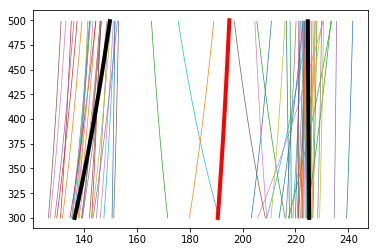

In [156]:
sp_params=[]
sp_cov=[]
sp_ave=[]
sp_f=list(range(300, 501, 5))
for fq in sp_f:
    sp_ave.append(pl_av(frequency=fq,phase=[]))
#Graph what the average components are doing
ax1,ay1=create_pl_fit(300,500,74.480,0.147)
py.plot((np.array(ay1)-36),ax1,lw=4,color='black', zorder=100000)   
ax2,ay2=create_pl_fit(300,500,267.242,-0.004)
py.plot((np.array(ay2)-36),ax2,lw=4,color='black', zorder=100000)    
#py.axis([100,275,300,500])

for a in range(9661):
    #Load in a pulse at a time
    print(a,pulse_names[a][-19:-9])
    single_pulse = np.loadtxt(fname=pulse_names[a], dtype=fulldatatype)
    no_freq_bands = max(single_pulse['frequency'])+1

    fit_spulse = []

    #Look at one frequency at a time
    for b in range(no_freq_bands):
        freqband = b
        f = single_pulse['frequency'] == freqband

        x=single_pulse['phase'][f]
        y=single_pulse['intensity'][f]

        noise = sigmaClip(y)
        error = np.nanstd(noise[1])

        if len(y)!=0:
            fit, params, sigma, cov, chir=fitting_gaussians(x,y,error)
    
        #Find the peaks at each frequency and add to an array
        if fit!=[] and len(y)!=0:
            pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500)
            fit_spulse.append(pulse_subp)

    #Find the movement of pulse across frequency and fit equations to them
    comp1_fit = find_fits(fit_spulse)

    #For all pulses with a comp1 fit, graph the powerlaw equation
    if comp1_fit!=0 and comp1_fit[1]!=0 and comp1_fit[2][0][0]>0 and comp1_fit[1][0][1]<2 and comp1_fit[1][0][0]<700 and comp1_fit[1][0][0]>50:
        x1,y1=create_pl_fit(300,500,comp1_fit[1][0][0],comp1_fit[1][0][1])
        py.plot(y1,x1, lw=0.7)
        sp_params.extend(comp1_fit[1][0])
        sp_cov.append(comp1_fit[1][2])
        for i,fq in enumerate(sp_f):
            sp_ave[i][1].append(powerlaw(fq,comp1_fit[1][0][0],comp1_fit[1][0][1]))
        print(comp1_fit[1][0][0],comp1_fit[1][0][1])

#Create points which are the average of all the points at a given frequency
sp_pl=[]

#Put into arrays for graphing
for fq in sp_ave:
    sp_pl.append(average(fq[1]))

py.plot(sp_p1,sp_f,lw=4,color='red', zorder=50000)   

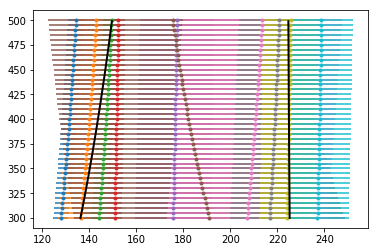

In [157]:
averages=[[] for i in range(20)]
errors=[[] for i in range(20)]
for i,n in enumerate(range(100,300,10)):
    ave_vals=[]
    cov_vals=[]
    param_vals=[]
    indices=np.where(np.logical_and(np.array(sp_ave[0][1])>=n, np.array(sp_ave[0][1])<(n+10)))
    if len(indices[0])!=0:
        for j in indices[0]:
            cov_vals.append(sp_cov[j])
            param_vals.append(sp_params[j*2])
            param_vals.append(sp_params[(j*2)+1])

        for fq in range(len(sp_ave)):
            ave_vals=[sp_ave[fq][1][m] for m in np.array(indices[0])]
            averages[i].append(average(ave_vals))
        errors[i]=find_y_err_pl(sp_f, param_vals, cov_vals)
        py.errorbar(averages[i],sp_f,xerr=errors[i],fmt='.')

ax1,ay1=create_pl_fit(300,500,74.480,0.147)
py.plot((np.array(ay1)-36),ax1,lw=2,color='black', zorder=100000)   
ax2,ay2=create_pl_fit(300,500,267.242,-0.004)
py.plot((np.array(ay2)-36),ax2,lw=2,color='black', zorder=100000)    
